# EP03 - Visão e processamento de imagens

Integrantes: 

- Bruna Lobato - 10666972
- Felipe Noronha - 10737032
- Izabela Fonsceca - 11583721

---

Você pode conferir as entregas anteriores e todas as imagens que constituem a base de dados no [GitHub do projeto](https://github.com/fcnoronha/visao-e-prcessamento-de-imagens).

## Introdução

Esse Jupyter Notebook representa o exercicio programa 3, que consiste em realizar a **segmentação das imagens dos objetos** e **classificação dos objetos utilizando aprendizado de maquina**.

In [1]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from scipy.ndimage import binary_fill_holes
from cv2 import boundingRect, rectangle

from skimage import io
from skimage.transform import resize 
from skimage.filters import threshold_sauvola
from skimage.metrics import adapted_rand_error
from skimage.morphology import remove_small_objects
from skimage.util import img_as_ubyte, img_as_float, img_as_int

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# caminhos para os datasets
RAW_PATH = 'datasets/raw/'
GREY_PATH = 'datasets/original-gray/'
NORM_PATH = 'datasets/normalized/'
AUG_PATH = 'datasets/augmented/'
MANUAL_SEGMENTED_PATH = 'datasets/segmented/manual/'
AUTOM_SEGMENTED_PATH = 'datasets/segmented/automated/'
MANUAL_FERET_PATH = 'datasets/feret_box/manual/'
AUTOM_FERET_PATH = 'datasets/feret_box/automated/'

# Parte1 - Segmentação e Feret Box

A segmentação consiste em demarcar o objeto de interesse na imagem. Em particular, criamos uma imagem binaria onde os pixels com valor 1 cobrem o objeto e os com valor 0 cobrem o fundo. Utilizamos dois metodos para geração das imagens segmentadas:

- Manual, onde utilizamos um editor de imagens para geração de segmentações que oferecessem um _ground-truth_, e
- Automática, utilizando funções da biblioteca `skimage` para tornar a classificação de todas as imagens do dataset algo factivel.

Além disso, nessa parte, vamos gerar as _Feret Boxes_ das imagens segmentadas, tanto manualmente quanto automaticamente.

## Segmentação manual

Para realizar a segmentação manual, selecionamos 175 imagens aleatorias da nossa base de dados original, o que representa 15% das imagens. Em seguida, usamos o software de edição de imagens GIMP para criar as segmentações. As imagens dessa parte ficam em `datasets/segmented/manual`.

Uma pequena amostra das imagens segmentadas é apresentada a seguir.

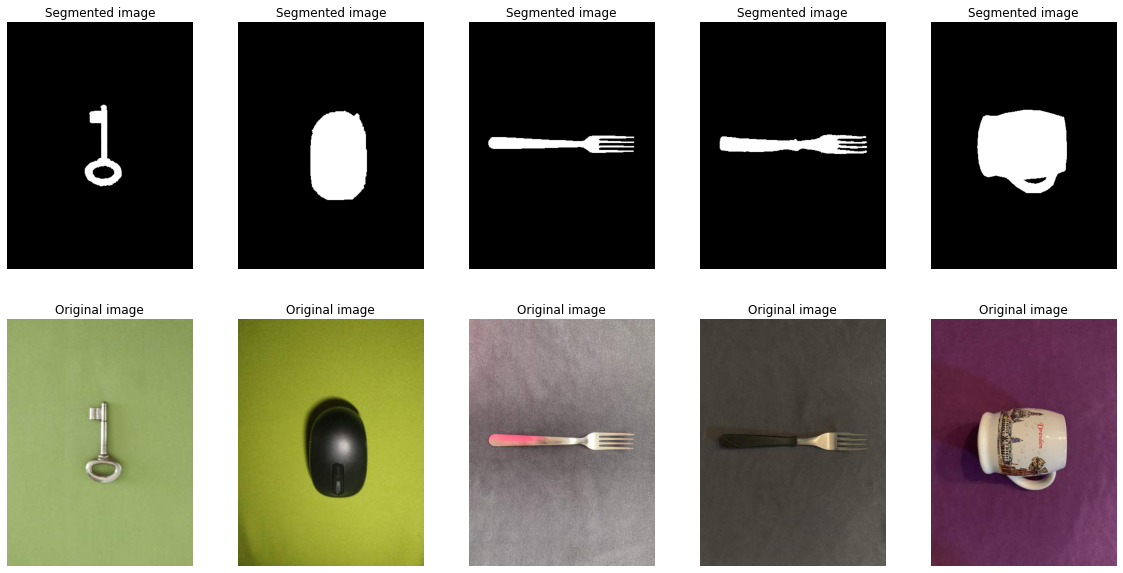

In [60]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(MANUAL_SEGMENTED_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file_name in zip(range(6), selection):
    
    segmented_image = io.imread(MANUAL_SEGMENTED_PATH + file_name)
    ax[0, i%n_images_to_show].imshow(segmented_image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Segmented image')

    original_image = io.imread(RAW_PATH + file_name[:-3] + 'jpg')
    ax[1, i%n_images_to_show].imshow(original_image, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Original image')

plt.show()

## Segmentação automatica

Para lidar com as mais de mil imagens originais, vamos utilizar metodos da biblioteca `skimage` para realizarmos a segmentação automatica utilizando o metodo [`threshold_sauvola`](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_sauvola). Além disso, vamos usar o metodo [`binary_fill_holes`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html) do _ndimage_ para preencher buracos na segmentação junto com o [`remove_small_objects`](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects) para remover pontinhos da imagem.

As imagens dessa parte ficam em `datasets/segmented/automated`.


In [38]:
def segment_image(image):
    
    threshold = threshold_sauvola(image, window_size=35)
    mask = image > threshold

    # invert if the object (smaller part) is not white
    n_black = np.count_nonzero(mask == False)
    n_white = np.count_nonzero(mask == True)
    if (n_white > n_black):
        mask = np.bitwise_not(mask)

    mask_without_points = remove_small_objects(mask > 0, 64)
    segmentation_filled = binary_fill_holes(mask_without_points)

    return segmentation_filled

for file in os.listdir(GREY_PATH):
        
    image_name = file.split('.')[0]
    image = io.imread(GREY_PATH + file, as_gray=True)
    segmentation = segment_image(image)

    io.imsave(AUTOM_SEGMENTED_PATH + image_name + '.png', img_as_ubyte(segmentation), check_contrast=False)

Abaixo, podemos ver alguns exemplos das imagens segmentadas automaticamente.

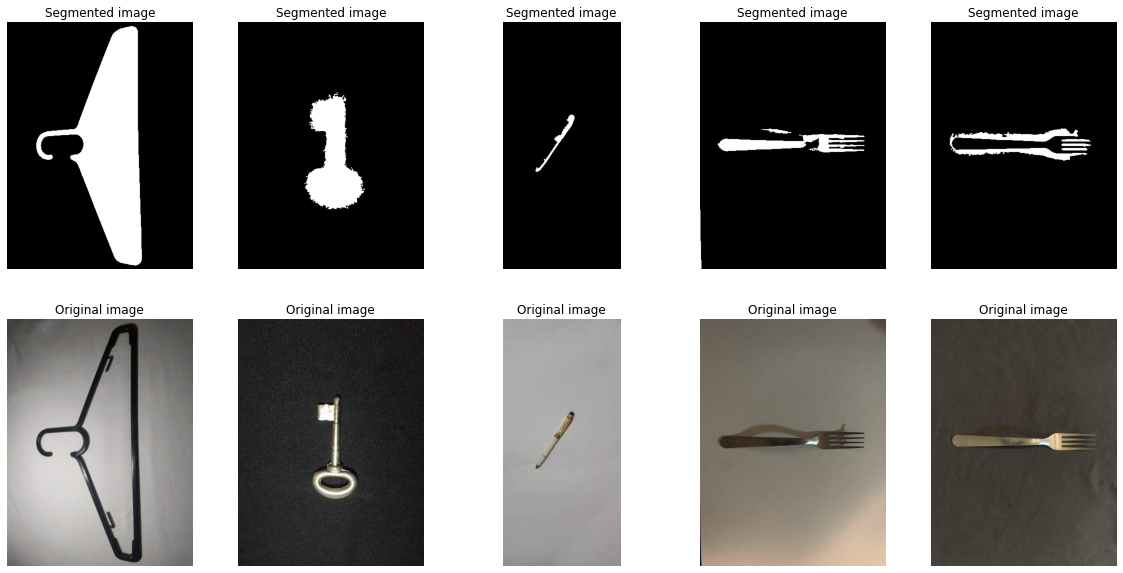

In [61]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(AUTOM_SEGMENTED_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file_name in zip(range(6), selection):
    
    segmented_image = io.imread(AUTOM_SEGMENTED_PATH + file_name)
    ax[0, i%n_images_to_show].imshow(segmented_image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Segmented image')

    original_image = io.imread(RAW_PATH + file_name[:-3] + 'jpg')
    ax[1, i%n_images_to_show].imshow(original_image, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Original image')

plt.show()

## Feret box

Abaixo, usamos metodos da biblioteca _cv2_ para calcular as _feret boxes_ das segmentações.

In [65]:
def generate_feret_box(image):

    x_left, y_top, width, heigth = boundingRect(image)
    feret_box = rectangle(image, (x_left, y_top), (x_left+width, y_top+heigth), 255, -1)
    return feret_box

for file in os.listdir(AUTOM_SEGMENTED_PATH):
        
    image = io.imread(AUTOM_SEGMENTED_PATH + file, as_gray=True)
    feret_box = generate_feret_box(image.astype(np.uint8))

    io.imsave(AUTOM_FERET_PATH + file, img_as_ubyte(feret_box), check_contrast=False)

for file in os.listdir(MANUAL_SEGMENTED_PATH):
        
    image = io.imread(MANUAL_SEGMENTED_PATH + file, as_gray=True)
    feret_box = generate_feret_box(image.astype(np.uint8))

    io.imsave(MANUAL_FERET_PATH + file, img_as_ubyte(feret_box), check_contrast=False)

Abaixo, podemos ver algumas _feret boxes_ geradas a partir das imagens segmentadas manualmente.

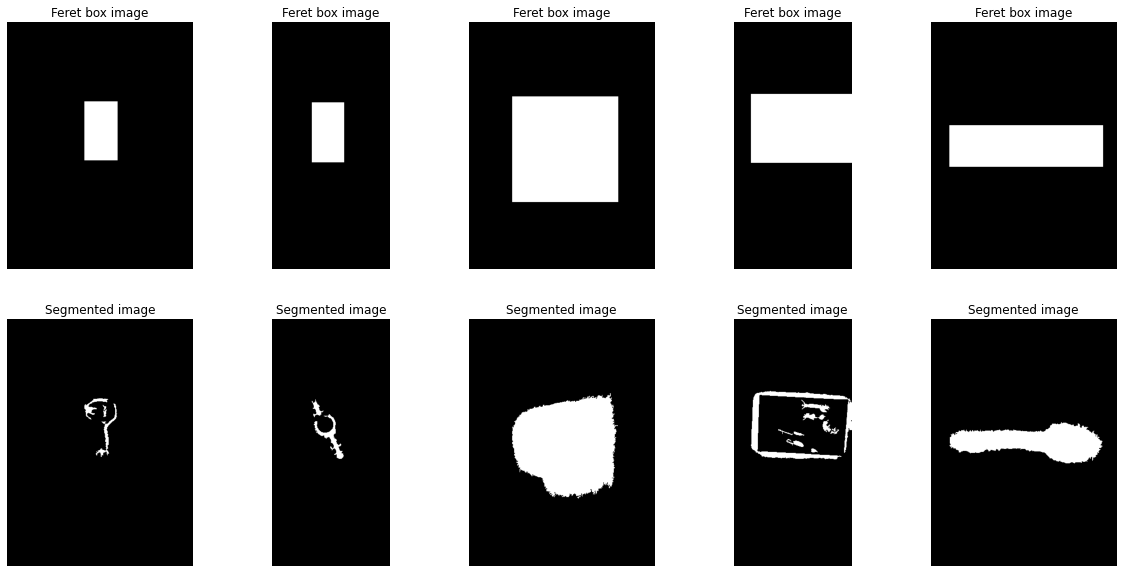

In [66]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(AUTOM_SEGMENTED_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file_name in zip(range(6), selection):
    
    segmented_image = io.imread(AUTOM_FERET_PATH + file_name)
    ax[0, i%n_images_to_show].imshow(segmented_image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Feret box image')

    original_image = io.imread(AUTOM_SEGMENTED_PATH + file_name)
    ax[1, i%n_images_to_show].imshow(original_image, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Segmented image')

plt.show()

# Parte 2 - Extração de features, PCA e classificação

Nessa segunda parte faremos a extração de _features_, redução de dimensionalidade usando PCA e classificação com _support vector machines_.

## Extração de features

Aqui, recortamos o pedaço da imagem compreendido pela Feret box e fizemos a sua rediomensionalização para o tamanho $400 \times 400$. Em seguida, achatamos essa imagem redimensionada para um vetor 1D. Esse vetor irá ser a _feature_ que iremos passar para o PCA.

In [4]:
# vector with (feature, file name) pairs
features_extracted = []
for file in os.listdir(AUG_PATH):

    file_name = file.split('.')[0]

    if (file_name.split('_')[-1] == 'col'): continue
    image = io.imread(AUG_PATH + file, as_gray=True)

    name_without_aug_suffix = file_name[:file_name.rfind('_')]
    feret_box = io.imread(AUTOM_FERET_PATH + name_without_aug_suffix + '.png', as_gray=True)
    x_left, y_top, width, heigth = boundingRect(feret_box)

    image_cropped = image[y_top:y_top+heigth, x_left:x_left+width]
    image_resized = resize(image_cropped, (200, 200), anti_aliasing=True)
    image_flattened = pd.Series(image_resized.flatten())
    features_extracted.append(( image_flattened, name_without_aug_suffix ))

Abaixo, temos a visualização de uma amostra das imagens recortadas e redimensionadas.

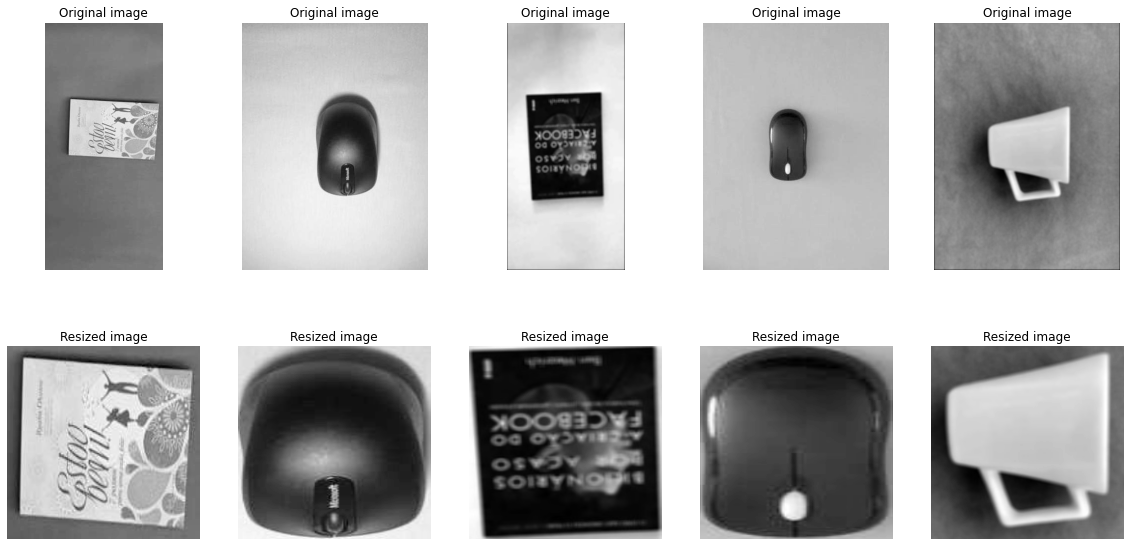

In [5]:
n_images_to_show = 5
selection = np.random.choice(os.listdir(AUG_PATH), n_images_to_show)

fig, ax = plt.subplots(2, n_images_to_show, figsize = (20, 10))
for i, file in zip(range(6), selection):
    
    file_name = file.split('.')[0]
    if (file_name.split('_')[-1] == 'col'): continue
    
    image = io.imread(AUG_PATH + file, as_gray=True)
    ax[0, i%n_images_to_show].imshow(image, cmap='gray')
    ax[0, i%n_images_to_show].axis('off')
    ax[0, i%n_images_to_show].set_title('Original image')

    name_without_aug_suffix = file_name[:file_name.rfind('_')]
    feret_box = io.imread(AUTOM_FERET_PATH + name_without_aug_suffix + '.png', as_gray=True)
    x_left, y_top, width, heigth = boundingRect(feret_box)
    image_cropped = image[y_top:y_top+heigth, x_left:x_left+width]
    image_resized = resize(image_cropped, (200, 200), anti_aliasing=True)
    ax[1, i%n_images_to_show].imshow(image_resized, cmap='gray')
    ax[1, i%n_images_to_show].axis('off')
    ax[1, i%n_images_to_show].set_title('Resized image')

plt.show()    

## Separação dos conjuntos

Nos dois blocos abaixo, fazemos a separação dos conjuntos de treinamento e teste com 80%, 20% da base original, respectivamente. Além disso, foi tomado um cuidado extra para garantir que variações de uma mesma imagem (transformações realizadas no dataset augmented) assim como as repetições de uma mesma fotografia, fiquem todas em um mesmo conjunto.

In [6]:
# names without extension and repetition number
file_names = list(set([file.split('.')[0][:-2] for file in os.listdir(GREY_PATH)]))
random.shuffle(file_names)

n_samples = len(file_names)
n_train = int(n_samples * 0.8)
n_test = n_samples - n_train

train_names = file_names[:n_train]
test_names = file_names[n_train:]

In [7]:
x_train = []
y_train = []
x_test = []
y_test = []

for feature, name in features_extracted:
    
    obj = name.split('_')[0]
    if name[:-2] in train_names:
        x_train.append(feature)
        y_train.append(obj)
    else:
        x_test.append(feature)
        y_test.append(obj)

## Redução de dimensionalidade

Agora, com as features devidamente selecionadas e conjuntos separados, vamos realizar a redução de dimensionalidade usando o PCA. Em particular, estamos interessados em manter 93% da variancia no dataset.

In [8]:
pca = PCA(n_components= 0.93)
pca.fit(pd.DataFrame(x_train))

x_train_pca = pca.transform(pd.DataFrame(x_train))
x_test_pca = pca.transform(pd.DataFrame(x_test))

print('Components after PCA:', x_train_pca.shape[1])

Components after PCA: 66


Tendo como base [este artigo](https://medium.com/@sebastiannorena/pca-principal-components-analysis-applied-to-images-of-faces-d2fc2c083371) fazemos a vizualição de alguns autovetores encontrados pelo PCA.

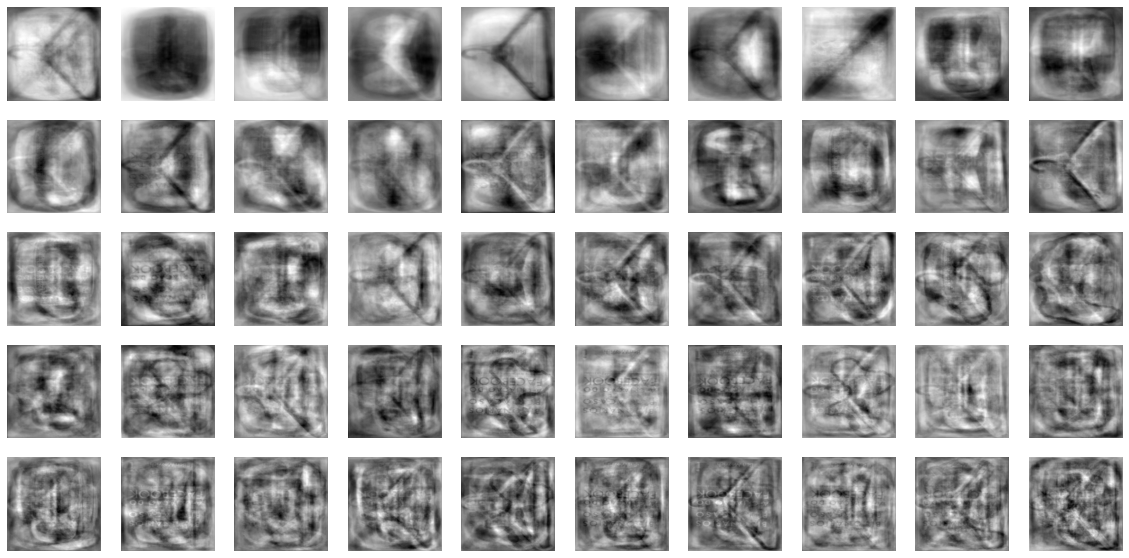

In [9]:
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(200,200), cmap='gray')
    ax.axis('off')

Além disso, podemos fazer o caminho de volta, reconstruindo uma imagem atraves da sua forma reduzida pelo PCA.

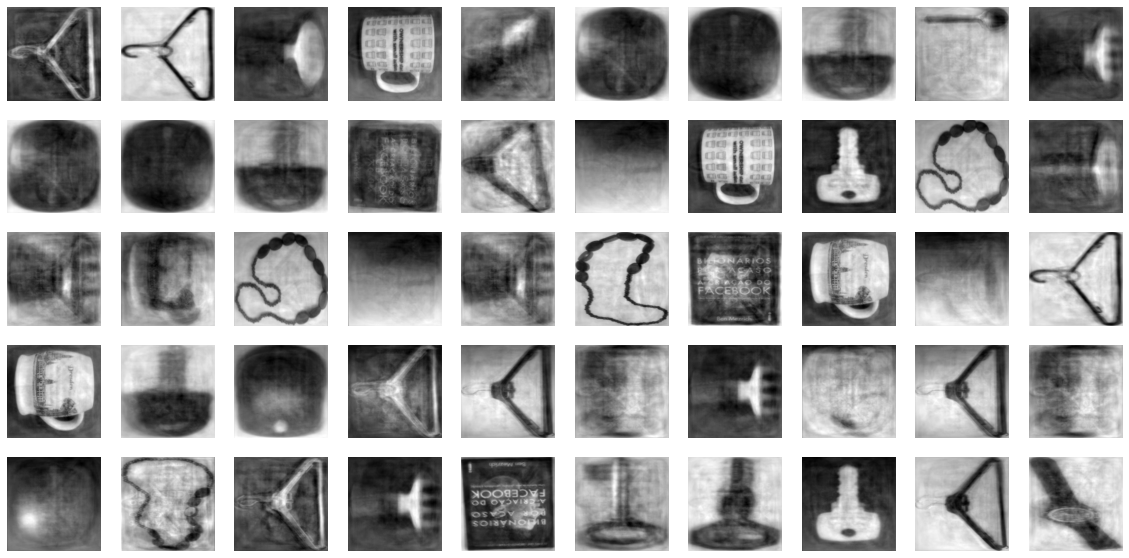

In [10]:
reconstructed_images_pca = pca.inverse_transform(x_train_pca)

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructed_images_pca[i].reshape(200, 200),cmap="gray")
    ax.axis('off')

## Classificação

Finalmente, usaremos _Support vector machines_ para realizar a Classificação dos objetos. Em particular, utilizaremos a _C-Support Vector Classification_. Além disso, usamos o metodo `GridSearchCV`, que realiza uma busca nos parametros definidos para encontrar aqueles que geram o modelo mais perfomatico.

In [11]:
from time import time
print("Fitting the classifier to the training set")
t0 = time()

param_grid = {
    'C': [1e1, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1]
}

clf = GridSearchCV( SVC(class_weight='balanced'), param_grid)
clf = clf.fit(x_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search: ", clf.best_estimator_)

Fitting the classifier to the training set
done in 293.911s
Best estimator found by grid search:  SVC(C=10.0, class_weight='balanced', gamma=0.0001, kernel='linear')


# Parte 3 - Metricas

##  Metricas da classificação

In [12]:
y_pred = clf.predict(x_test_pca)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      cabide       0.84      0.95      0.89       150
      caneca       0.93      0.86      0.89       134
      caneta       0.53      0.50      0.51        90
       chave       0.62      0.66      0.64       150
       colar       0.49      0.85      0.62        60
      colher       0.74      0.75      0.74        75
       garfo       0.75      0.48      0.59       115
       livro       0.65      0.73      0.69       120
       mouse       0.74      1.00      0.85       105
     relogio       0.78      0.44      0.56       165

    accuracy                           0.71      1164
   macro avg       0.71      0.72      0.70      1164
weighted avg       0.73      0.71      0.70      1164



**Conclusão**: Os resultados acima mostram que o modelo teve uma boa performance pra maioria das classes. No caso do relógio e do garfo, temos que o modelo classificou mais da metade dos exemplos de teste errado. Isso pode ter acontecido pelo fato de no momento da redução de resolução o garfo ter ficado distorcido e no caso do relógio, de termos fotos dos mesmos de lado, fazendo com que ele pudesse ser confundido com outro objeto como o colar. O colar, apresentou uma precisão menor do que 50%, indicando que mais da metade dos exemplos classificados como colar estavam errados, provavelmente porque era um objeto mais complexo de classificar. Finalmente, para a caneta, temos que tanto a precision quanto o recall tiveram valores ruins, o que precisaria ser mais investigado. Acreditamos que a utilização de modelos mais complexos, como CNN por exemplo, poderiam melhorar consideravelmente os resultados. 

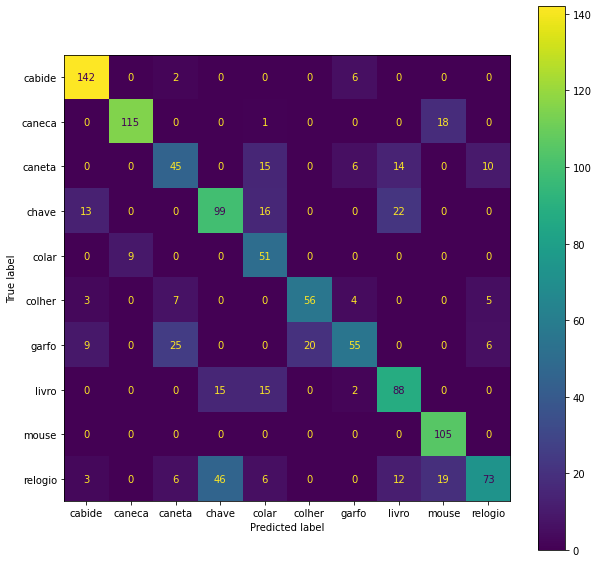

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, x_test_pca, y_test, ax=ax)
plt.show()  

## Metricas da segmentação

Por ultimo, fazemos avaliação tanto da segmentação quanto das feret box, comparando o ground truth com as realizadas automaticamente. Para isso, vamos utilizar a métrica de _intersection over union_. Nessa metrica, quanto mais perto de 1, melhor. Ademais, calculamos a media para cada classe, após isso, podemos calcular para todo o nosso dataset fazendo a media dessas medias.

In [14]:
def calc_iou(ground_truth, generated):
    intersection = np.logical_and(ground_truth, generated)     
    union = np.logical_or(ground_truth, generated)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

segmentation_metrics = {}
for file in os.listdir(MANUAL_SEGMENTED_PATH):
    if ".png" in file:
        ground_truth_image = io.imread(MANUAL_SEGMENTED_PATH + file, as_gray=True) > 0
        automatic_segmented_image = io.imread(AUTOM_SEGMENTED_PATH + file, as_gray=True) > 0

        obj = file.split('_')[0]
        
        if obj not in segmentation_metrics:
            segmentation_metrics[obj] = []
        segmentation_metrics[obj].append(calc_iou(ground_truth_image, automatic_segmented_image))

feret_metrics = {}
for file in os.listdir(MANUAL_FERET_PATH):
    if ".png" in file:
        ground_truth_image = io.imread(MANUAL_FERET_PATH + file, as_gray=True) > 0
        automatic_segmented_image = io.imread(AUTOM_FERET_PATH + file, as_gray=True) > 0

        obj = file.split('_')[0]
        
        if obj not in feret_metrics:
            feret_metrics[obj] = []
        feret_metrics[obj].append(calc_iou(ground_truth_image, automatic_segmented_image))

metrics = []
total_segmentation = []
total_feret = []
for obj in segmentation_metrics:
    metrics.append( [obj, np.mean(segmentation_metrics[obj]), np.mean(feret_metrics[obj])] )
    total_segmentation.append(np.mean(segmentation_metrics[obj]))
    total_feret.append(np.mean(feret_metrics[obj]))

metrics.append( ['dataset', np.mean(total_segmentation), np.mean(total_feret)] )
print(pd.DataFrame(metrics, columns=['Object', 'Segmentation IoU', 'Feret Box IoU']))

     Object  Segmentation IoU  Feret Box IoU
0    caneta          0.348824       0.741361
1     chave          0.510774       0.745648
2     colar          0.391864       0.813819
3     mouse          0.536440       0.792630
4    colher          0.490265       0.598390
5    cabide          0.214194       0.924464
6   relogio          0.526914       0.686544
7     garfo          0.332302       0.477930
8     livro          0.478186       0.759034
9    caneca          0.437637       0.658039
10  dataset          0.426740       0.719786


Podemos ver acima que a segmentação não teve bons resultados, mas com o Feret Box tivemos uma melhora do resultado. 